# geemap-tools: Demonstração de Funcionalidades

Autor: [Andre L. Belem](mailto:andrebelem@id.uff.br)<br>
Versão: Abril 2025<br>
**Atualizações:**
- Julho 2025: refatoração de alguns códigos, melhoria nos markdowns explicativos e novas funções.

Este notebook apresenta exemplos práticos das principais funções disponíveis no pacote `geemap-tools`. As rotinas foram desenvolvidas para facilitar o uso do Google Earth Engine com o auxílio das bibliotecas `geemap`, focando especialmente em usuários que desejam realizar análises geoespaciais sem a necessidade de programar em Python avançado.


Se estiver no Google Colab, instale as dependências necessárias com:

```python
!pip install git+https://github.com/andrebelem/geemap-tools.git
```

**Atenção**: por compatibilidade com o github, todas as saídas deste jupyter foram apagadas. Rode em seu ambiente para gerar imagens e dados.
O `geemap-tools`irá instalar várias bibliotecas incluindo `xarray`, `rioxarray`, `eemont`, `geopandas` entre outros.

**Note** que a primeira etapa é a instalação dos pacotes essenciais

In [ ]:
# esta célula deve ser rodada no colab para instalar o pacote
#!pip install git+https://github.com/andrebelem/geemap-tools.git
#print("Instalação concluída.")

Depois disso, basta começar como de costume inicializando o `ee` e o `geemap`.

In [1]:
import warnings ## <- apenas para deixar a saída mais limpa. Se quiser pode comentar.
warnings.filterwarnings("ignore", category=UserWarning)

import ee
import geemap
import geemap_tools as gee
ee.Authenticate()
ee.Initialize(project='ee-andrebelem') # << note que vc tem que mudar para o seu projeto

### Lendo e Gravando uma Região de Interesse (ROI)

Neste pacote, você pode definir sua Região de Interesse (ROI) de duas maneiras:  
- Diretamente por código, se já souber as coordenadas ou área desejada.
- De forma interativa, desenhando sobre o mapa.

Aqui você pode usar duas funções uteis: `roi_to_file` e `file_to_roi`.

No exemplo abaixo, criamos um mapa centrado na Floresta da Tijuca e definimos um `roi` manualmente.  
Em seguida, mostramos como utilizar a função `roi_to_file` para salvar essa ROI em disco.  
Essa funcionalidade é especialmente útil para manter suas regiões organizadas ou compartilhá-las facilmente com outros usuários.

📽️ [Clique aqui para assistir ao vídeo "Como criar um ROI no geemap"](https://github.com/andrebelem/geemap-tools/blob/main/exemplos/Como_criar_um_ROI_geemap.mp4)

> Este vídeo demonstra passo a passo como selecionar uma região de interesse (ROI) no Google Earth Engine usando `geemap`.




In [3]:
map = geemap.Map(center=[-22.85, -43.16], zoom=10)
map.add_basemap("Esri.WorldImagery")
map

Map(center=[-22.85, -43.16], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [5]:
# definindo o roi via `user_roi` do geemap.
roi = map.user_roi

gee.roi_to_file(roi, 'Floresta_da_Tijuca', format='shp') # converte em um arquivo shape e grava no disco

'C:\\Users\\abelem\\Documents\\GitHub\\geemap-tools\\Floresta_da_Tijuca.shp'

### Utilizando um ROI já salvo

Para garantir consistência nos exemplos, vamos utilizar um arquivo de ROI já disponível no repositório do `geemap-tools`, contendo o shapefile da Floresta da Tijuca.

Neste caso, utilizamos a função `file_to_roi` do pacote `geemap_tools` para ler o arquivo e carregar a região de interesse diretamente.


In [ ]:
# caso você esteja no google colab, pode obter o shape daqui
#!wget https://github.com/andrebelem/geemap-tools/raw/refs/heads/main/exemplos/Floresta_da_Tijuca_original.zip

In [2]:
tijuca = gee.file_to_roi("Floresta_da_Tijuca_original.zip").geometry() # necessário para pegar apenas a tijuca como roi

In [3]:
# note que você pode usar a rotina `describe_roi`do geemap
gee.analysis.describe_roi(tijuca)

📐 Área total: 98.20 km²
📏 Perímetro total: 49.35 km


,Resolução (m),Área de pixel (m²),Nº estimado de pixels
0,10,100,982003
1,30,900,109111
2,60,3600,27278


{'area_km2': 98.20025473025349,
 'perimetro_km': 49.35211809930279,
 'n_pixels': {'10m': 982003, '30m': 109111, '60m': 27278},
 'df':    Resolução (m)  Área de pixel (m²)  Nº estimado de pixels
 0             10                 100                 982003
 1             30                 900                 109111
 2             60                3600                  27278}

In [4]:
# Ou para apenas obter os valores:
info = gee.analysis.describe_roi(tijuca, show_pixels_table=False, print_summary=False)
print(info["n_pixels"])

{'10m': 982003, '30m': 109111, '60m': 27278}


#### Observação sobre Limites de Processamento no Google Earth Engine

Operações no Google Earth Engine (GEE) como `reduceRegion`, `sample`, `getDownloadURL` ou `export` estão sujeitas a limites internos de uso, tanto em termos de número de pixels quanto de volume total de dados. Esses limites variam dependendo do tipo de operação, da quantidade de bandas e da resolução espacial dos dados utilizados.

##### Limites Comuns:

- Operações como `reduceRegion` ou `getDownloadURL` geralmente funcionam com até cerca de 1 a 5 milhões de pixels. Acima disso, podem ocorrer erros de memória ou tempo de execução.
- Exportações que envolvem imagens maiores que 5000 x 5000 pixels (25 milhões de pixels) tendem a falhar, especialmente se houver muitas bandas.
- O tempo máximo de execução de operações client-side no GEE costuma ser limitado (aproximadamente 5 minutos).

##### Erros Comuns:

- `User memory limit exceeded`
- `Image too large for exporting`
- `Computation timed out`
- `Too many pixels in region`

##### Boas Práticas:

- Reduzir a área de interesse ou subdividi-la em regiões menores.
- Trabalhar com menos bandas ou índices espectrais, se possível.
- Usar resoluções espaciais mais baixas quando o objetivo permitir.
- Priorizar o uso de `reduceRegions` ou `export` com limites explícitos de escala e geometria simplificada.

Evitar exceder esses limites ajuda a garantir a estabilidade do código e o sucesso das operações no ambiente do GEE.


### Listando Imagens de Satélite com `list_sat_images`

A função `list_sat_images` permite listar rapidamente todas as imagens de satélite disponíveis em uma coleção do Google Earth Engine para uma determinada região de interesse (ROI) e intervalo de datas.

Ela gera um DataFrame organizado com informações úteis como:
- Data de aquisição
- Percentual de nuvens
- Nome do satélite
- Azimute e elevação solar
- Percentual de interseção com a ROI

Essa rotina é extremamente útil para ter uma visão geral da disponibilidade de imagens antes de iniciar análises mais complexas.  
Com ela, é possível verificar rapidamente a cobertura de nuvens, selecionar os melhores períodos de imagem, e identificar lacunas temporais nos dados.

**Atenção:** dependendo da coleção escolhida (por exemplo, coleções diárias ou de alta frequência como Sentinel-2), a lista gerada pode ser bastante extensa, especialmente em áreas tropicais ou durante períodos longos de tempo.  
É recomendado ajustar bem a data e o ROI para evitar carregar milhares de registros desnecessariamente.

Outro ponto importante é que `list_sat_images` foi otimizada para funcionar especialmente com coleções do tipo **Landsat** e **Sentinel**. A função identifica automaticamente o tipo de satélite, organizando corretamente os metadados para facilitar a seleção posterior. Essa rotina torna o planejamento de análises de séries temporais, mosaicos ou filtragem por qualidade muito mais eficiente e acessível.


In [5]:
# Vamos usar o Landsat 8 Collection 2 Tier 1 e Level 2 (Produtos de Superífice Corrigida)
# note que se você comentar o `time_range`, ele vai fazer para todo o produto ! O que demora cerca de 5 minutos

df_landsat = gee.list_sat_images(
    collection_id="LANDSAT/LC08/C02/T1_L2",
    roi=tijuca,
    time_range=("2025-01-01", "2025-12-31"),
    max_imgs=500,
    compute_clear_sky=True
)

Coletando metadados: 100%|███████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.30s/it]


In [6]:
df_landsat # verificando consistência do arquivo

,id,date,satellite,img_cloud_cover,solar_elevation,solar_azimuth,proportion_roi_%,clear_sky_%
0,LANDSAT/LC08/C02/T1_L2/LC08_217076_20250107,2025-01-07 12:52:04.673,LANDSAT_8,87,61,95,100.0,10.2
1,LANDSAT/LC08/C02/T1_L2/LC08_217076_20250123,2025-01-23 12:51:58.624,LANDSAT_8,25,59,89,100.0,56.6
2,LANDSAT/LC08/C02/T1_L2/LC08_217076_20250208,2025-02-08 12:52:02.749,LANDSAT_8,13,57,82,100.0,67.0
3,LANDSAT/LC08/C02/T1_L2/LC08_217076_20250224,2025-02-24 12:51:52.524,LANDSAT_8,2,55,72,100.0,97.3
4,LANDSAT/LC08/C02/T1_L2/LC08_217076_20250312,2025-03-12 12:51:49.365,LANDSAT_8,16,52,63,100.0,82.5
5,LANDSAT/LC08/C02/T1_L2/LC08_217076_20250328,2025-03-28 12:51:39.031,LANDSAT_8,5,49,54,100.0,86.2
6,LANDSAT/LC08/C02/T1_L2/LC08_217076_20250413,2025-04-13 12:51:33.950,LANDSAT_8,32,46,46,100.0,16.6
7,LANDSAT/LC08/C02/T1_L2/LC08_217076_20250515,2025-05-15 12:51:24.527,LANDSAT_8,8,39,37,100.0,96.2
8,LANDSAT/LC08/C02/T1_L2/LC08_217076_20250531,2025-05-31 12:51:28.396,LANDSAT_8,39,36,35,100.0,90.3
9,LANDSAT/LC08/C02/T1_L2/LC08_217076_20250616,2025-06-16 12:51:38.936,LANDSAT_8,0,35,35,100.0,97.4


O DataFrame gerado pela função `list_sat_images` apresenta uma tabela com os principais atributos de cada imagem localizada para a coleção e intervalo de datas escolhidos.

Cada linha da tabela corresponde a uma imagem individual, e as colunas representam:

- **id**: Identificador completo da imagem na coleção do Earth Engine.
- **date**: Data e hora de aquisição da imagem.
- **satellite**: Nome do satélite que capturou a imagem (neste caso, sempre `LANDSAT_8`).
- **img_cloud_cover**: Percentual de cobertura de nuvens reportado na imagem.
- **solar_elevation**: Ângulo de elevação solar no momento da aquisição, em graus.
- **solar_azimuth**: Azimute solar (posição do sol em relação ao norte), em graus.
- **proportion_roi_%**: Percentual da região de interesse (ROI) coberta pela imagem.
- **clear_sky_%**: Percentual da ROI livre de nuvens, calculado usando a máscara de nuvem (`QA_PIXEL`).

---

Este resultado permite filtrar rapidamente as melhores imagens para análise, priorizando, por exemplo, aquelas com maior `clear_sky_%` e menor `img_cloud_cover`.

Note que `clear_sky_%` é bem consistente com `img_cloud_cover`.

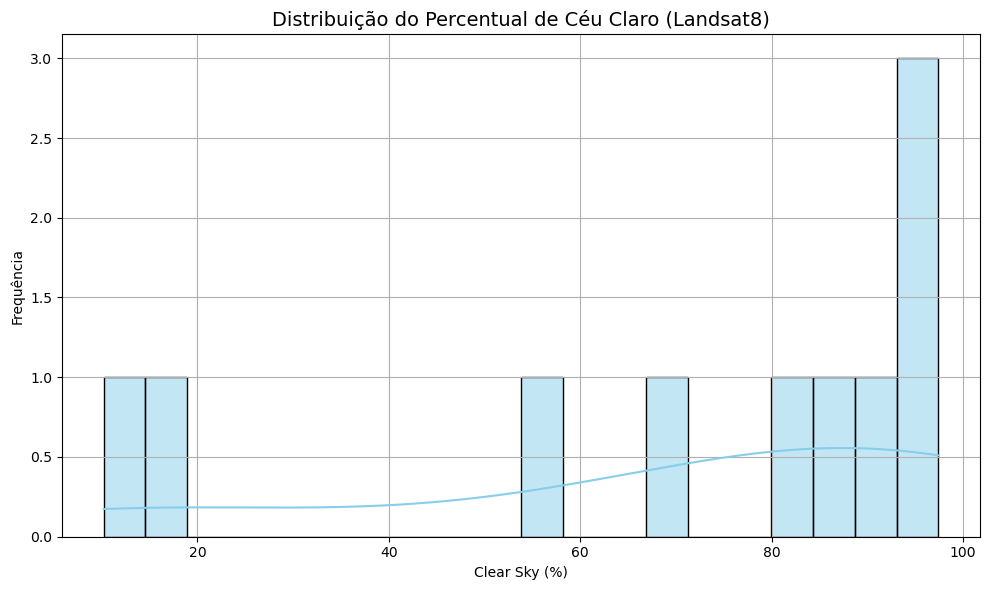

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Remove valores nulos ou NaN
df_plot = df_landsat.dropna(subset=['clear_sky_%'])

# Cria o histograma
plt.figure(figsize=(10, 6))
sns.histplot(df_plot['clear_sky_%'], bins=20, kde=True, color='skyblue')

# Ajustes visuais
plt.title('Distribuição do Percentual de Céu Claro (Landsat8)', fontsize=14)
plt.xlabel('Clear Sky (%)')
plt.ylabel('Frequência')
plt.grid(True)

# Exibe
plt.tight_layout()
plt.show()

**Note** que há poucas imagens com Clear Sky % <20 ! Use essa informação para você selecionar as imagens da coleção que você quer trabalhar.<br>

Agora vamos obter o mesmo resultado para o sentinel. Veja que coloquei um range de datas aqui ! porque há muitos dados do Sentinel. Caso você queria obter a tabela do repositório inteiro, fique atento ao `max_imgs` de retorno.

**Observação**: principalmente par ao Sentinel, o cálculo de clear_sky_% depende de uma interação massiva com as imagens. Tenha *paciência* pois esse trecho pode demorar alguns minutos, mas vale a pena ! pois assim você já terá todos os dados das imagens que precisa. Lembrando que para ROIs pequenos, as vezes o `img_cloud_cover`(que é o percentual da imagem completa coberta de nuvens) não irá representar o real "cloud cover" sobre o ROI. Por isso é interessante ter paciência aqui na sua análise.

In [5]:
# Chamada da função principal
df_sentinel = gee.list_sat_images(
    collection_id="COPERNICUS/S2_SR_HARMONIZED",
    roi=tijuca,
    max_imgs=500,
    compute_clear_sky=True,
    time_range=("2025-01-01", "2025-01-31")
)

Coletando metadados: 100%|█████████████████████████████████████████████████████████| 5/5 [00:12<00:00,  2.49s/it]


In [6]:
df_sentinel # e o resultado ...

,id,date,satellite,img_cloud_cover,solar_elevation,solar_azimuth,proportion_roi_%,clear_sky_%
0,COPERNICUS/S2_SR_HARMONIZED/20250102T130249_20...,2025-01-02 13:08:36.451,Sentinel-2B,16,65,95,100.0,56.5
1,COPERNICUS/S2_SR_HARMONIZED/20250112T130249_20...,2025-01-12 13:08:35.975,Sentinel-2B,93,64,92,100.0,0.0
2,COPERNICUS/S2_SR_HARMONIZED/20250117T130241_20...,2025-01-17 13:08:35.052,Sentinel-2A,30,63,90,100.0,95.8
3,COPERNICUS/S2_SR_HARMONIZED/20250122T130249_20...,2025-01-22 13:08:37.798,Sentinel-2B,71,63,88,100.0,29.6
4,COPERNICUS/S2_SR_HARMONIZED/20250127T130311_20...,2025-01-27 13:09:04.429,Sentinel-2C,97,62,86,100.0,0.0


In [7]:
# note que você pode calcular o percentual de céu claro com seu ROI sobre uma imagem única
import ee
from geemap_tools.clouds import get_clear_sky_percentage

# Define a imagem Sentinel-2 harmonizada
img = ee.Image("COPERNICUS/S2_SR_HARMONIZED/20250102T130249_20250102T130726_T23KPQ")

# Define sua ROI (exemplo: já definida como tijuca)
# tijuca = gee.file_to_roi("Floresta_da_Tijuca_original.zip").geometry()

# Calcula o percentual de céu claro
clear_sky = get_clear_sky_percentage(img, roi=tijuca, debug=True)

print(f"Percentual de céu claro: {clear_sky} %")

Percentual de céu claro: 56.5 %


In [8]:
# vamos criar um mapa para mostrar como essa imagem se apresenta
Map = geemap.Map()
Map.centerObject(tijuca, zoom=11)
Map.addLayer(img, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'RGB')
Map.addLayer(tijuca, {'color': 'blue'}, 'ROI Tijuca')
Map

Map(center=[-22.949512677160616, -43.28100173805031], controls=(WidgetControl(options=['position', 'transparen…

### Visualizando Nuvens em uma Imagem Landsat 8

Neste exemplo, selecionamos uma imagem do Landsat 8 que possui presença significativa de nuvens, com o objetivo de visualizar tanto a imagem original quanto a máscara de nuvens gerada a partir do atributo `QA_PIXEL`.

Os passos realizados são:

- Selecionar uma imagem específica da coleção `LANDSAT/LC08/C02/T1_L2`.
- Visualizar a banda vermelha (`SR_B4`) em tons de cinza para facilitar a identificação visual.
- Criar uma máscara de nuvens utilizando o bit 3 da banda `QA_PIXEL`, que indica a presença de nuvens.
- Adicionar ao mapa a imagem original, a máscara de nuvens destacada em vermelho e o contorno da região de interesse (Floresta da Tijuca).


In [9]:
# Seleciona a imagem Landsat 8 que tem nuvens
img = ee.Image("LANDSAT/LC08/C02/T1_L2/LC08_217076_20180613")

# Seleciona uma banda visível para visualização em tons de cinza
gray_vis = {
    'bands': ['SR_B4'],  # Banda vermelha
    'min': 5000,
    'max': 16000,
    'gamma': 1.2
}

# Cria o mapa centrado na imagem
Map = geemap.Map()
Map.centerObject(tijuca, zoom=11)

# Adiciona a imagem original em escala de cinza
Map.addLayer(img, gray_vis, "Imagem em cinza (SR_B4)")

# Opcional: Adiciona a máscara de nuvem (QA_PIXEL bit 3)
cloud_mask = img.select('QA_PIXEL').bitwiseAnd(1 << 3).neq(0)
Map.addLayer(cloud_mask.updateMask(cloud_mask), {'palette': ['red']}, 'Máscara de nuvem (QA_PIXEL)')
# Adiciona o contorno do ROI
Map.addLayer(tijuca, {'color': 'blue'}, 'Floresta da Tijuca')

Map

Map(center=[-22.949512677160616, -43.28100173805031], controls=(WidgetControl(options=['position', 'transparen…

### Visualização de Nuvens em Imagens Sentinel-2

O código abaixo também pode ser usado para verificar a presença de nuvens em uma imagem Sentinel-2.  
A máscara é construída com base na banda `SCL`, que classifica pixels por tipo de cobertura, incluindo nuvens e sombras.  
A camada resultante destaca em vermelho as regiões com maior probabilidade de nuvem sobre a área de interesse.


In [10]:
# Carrega a imagem Sentinel-2 que também tem nuvens
img = ee.Image("COPERNICUS/S2_SR/20181225T130249_20181225T130243_T23KPQ")

# Visualização em tons de cinza (banda B4 - vermelho)
gray_vis = {
    'bands': ['B4'],  # Banda vermelha (10m)
    'min': 0,
    'max': 3000,
    'gamma': 1.2
}

# Cria máscara de nuvem com base na banda SCL
# Códigos 6, 7, 8, 9 representam diferentes tipos de nuvens
scl = img.select('SCL')
cloud_mask = scl.remap([6, 7, 8, 9], [1, 1, 1, 1], defaultValue=0).rename('cloud')
cloud_mask = cloud_mask.updateMask(cloud_mask)  # aplica máscara apenas onde há nuvem

# Cria o mapa
Map = geemap.Map()
Map.centerObject(tijuca, zoom=11)

# Adiciona a imagem em tons de cinza
Map.addLayer(img, gray_vis, "Imagem em cinza (B4 - Sentinel-2)")

# Adiciona a máscara de nuvem
Map.addLayer(cloud_mask, {'palette': ['red']}, 'Máscara de Nuvem (SCL)')

# Adiciona a ROI
Map.addLayer(tijuca, {'color': 'blue'}, 'Floresta da Tijuca')

Map

Map(center=[-22.949512677160616, -43.28100173805031], controls=(WidgetControl(options=['position', 'transparen…

## Análise de Séries Temporais com Sentinel-2

Neste exemplo, utilizaremos a função `list_sat_images` para consultar imagens Sentinel-2 e gerar uma série temporal de NDVI sobre a área definida.

Embora a coleção `COPERNICUS/S2_SR` contenha dados desde 2015, neste teste faremos uma consulta restrita ao intervalo entre **2024 e 2025**, com o objetivo de validar o desempenho e a resposta do Earth Engine em um período mais recente.

É importante destacar que, ao lidar com períodos mais longos — por exemplo, de 2015 a 2025 — o número de imagens pode ultrapassar 450 cenas, o que aumenta significativamente a carga de requisições. Em ambientes locais, isso pode causar lentidão, falhas ou até bloqueios temporários de conexão com o Earth Engine devido à sobrecarga da API.

Por boas práticas, recomenda-se dividir a busca por intervalos menores (ano a ano ou por estação do ano), garantindo maior controle e estabilidade no processamento.

Este teste serve também como demonstração das limitações locais e reforça a recomendação de executar análises longas em ambientes otimizados, como o Google Colab, onde a integração com o Earth Engine é mais fluida e robusta.

**Observação:** Uma execução completa entre 2015 e 2025 pode levar mais de **4 horas** apenas para listar as imagens. Portanto, estratégias de particionamento e uso em nuvem são fundamentais para projetos com séries temporais extensas.



In [12]:
df_sentinel = gee.list_sat_images(
    collection_id="COPERNICUS/S2_SR",
    roi=tijuca,
    max_imgs=500,
    compute_clear_sky=True,
    time_range=("2024-01-01", "2025-12-31") # note que aqui estou pegando apenas 2 anos - 116 imagens ~36 minutos
)

Coletando metadados: 100%|███████████████████████████████████████████████████| 116/116 [2:28:30<00:00, 76.82s/it]


## Criando uma Série Temporal do NDVI

Agora que já temos o `df_landsat` e `df_sentinel`, vamos criar uma série temporal utilizando a média e o desvio padrão do NDVI (Índice de Vegetação por Diferença Normalizada).

Vamos usar a função `index_to_timeseries`, que pode ser aplicada a qualquer índice disponível no pacote [`eemont`](https://eemont.readthedocs.io/en/latest/). Recomendo dar uma olhada na documentação para conhecer todos os índices suportados!

> ⚠️ Atenção: Se estiver trabalhando com conjuntos de dados muito grandes, essa operação pode demorar um pouco para ser concluída.


In [ ]:
# Supondo que você já tenha carregado 'tijuca' como ee.Geometry !
df_ndvi_landsat = gee.index_to_timeseries(df_landsat, tijuca, index_name='NDVI', debug=False)
df_ndvi_sentinel = gee.index_to_timeseries(df_sentinel, tijuca, index_name='NDVI', debug=False)

Verifique sempre o resultado !

In [ ]:
df_ndvi_landsat.head() # verificando...

Vamos fazer um plot comparativo ..... Modifique para sua aplicação

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ordena os DataFrames por data
df_ndvi_landsat = df_ndvi_landsat.sort_values("date")
df_ndvi_sentinel = df_ndvi_sentinel.sort_values("date")

# Cópias para o plot
df_ndvi_landsat_plot = df_ndvi_landsat.copy()
df_ndvi_sentinel_plot = df_ndvi_sentinel.copy()

# Filtro para visualização: clear_sky_% < 95 → NDVI_mean/std = NaN
df_ndvi_landsat_plot.loc[df_ndvi_landsat_plot['clear_sky_%'] < 95, ['NDVI_mean', 'NDVI_std']] = np.nan
df_ndvi_sentinel_plot.loc[df_ndvi_sentinel_plot['clear_sky_%'] < 95, ['NDVI_mean', 'NDVI_std']] = np.nan

# Inicia o gráfico
plt.figure(figsize=(12, 6))

# Faixa de std - Sentinel
plt.fill_between(
    df_ndvi_sentinel_plot['date'],
    df_ndvi_sentinel_plot['NDVI_mean'] - df_ndvi_sentinel_plot['NDVI_std'],
    df_ndvi_sentinel_plot['NDVI_mean'] + df_ndvi_sentinel_plot['NDVI_std'],
    color='green', alpha=0.1
)

# Faixa de std - Landsat
plt.fill_between(
    df_ndvi_landsat_plot['date'],
    df_ndvi_landsat_plot['NDVI_mean'] - df_ndvi_landsat_plot['NDVI_std'],
    df_ndvi_landsat_plot['NDVI_mean'] + df_ndvi_landsat_plot['NDVI_std'],
    color='blue', alpha=0.1
)

# Linha média do NDVI - Sentinel
sns.lineplot(
    data=df_ndvi_sentinel_plot,
    x='date', y='NDVI_mean',
    label='Sentinel-2 (linha)',
    color='green'
)

# Linha média do NDVI - Landsat
sns.lineplot(
    data=df_ndvi_landsat_plot,
    x='date', y='NDVI_mean',
    label='Landsat 8 (linha)',
    color='blue'
)

# ░░░ Pontos sobre a curva Sentinel, diferenciando por satélite ░░░
sentinel_symbols = {
    'Sentinel-2A': 'o',  # Círculo
    'Sentinel-2B': 's',  # Quadrado
    'Sentinel-2C': 'X',  # X
}

for sat, marker in sentinel_symbols.items():
    subset = df_ndvi_sentinel_plot[df_ndvi_sentinel_plot['satellite'] == sat]
    plt.scatter(
        subset['date'], subset['NDVI_mean'],
        color='green', marker=marker, s=60, label=f'{sat}'
    )

# ░░░ Pontos sobre a curva Landsat (inclusive onde NDVI_mean é NaN) ░░░
plt.scatter(
    df_ndvi_landsat['date'],
    df_ndvi_landsat_plot['NDVI_mean'],  # usa os NaN filtrados
    color='blue', marker='D', s=50, label='Landsat 8 (ponto)'
)

# Ajustes visuais
plt.title('Série Temporal do NDVI (clear_sky ≥ 95%)', fontsize=14)
plt.xlabel('Data')
plt.ylabel('NDVI médio sobre a ROI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Interpretação da Série Temporal de NDVI - Landsat vs Sentinel-2

A figura acima apresenta a série temporal do NDVI médio para duas plataformas de satélites:
- **Landsat 8** (em azul)
- **Sentinel-2A/B/C** (em verde, com símbolos diferentes para cada satélite)

É possível observar que o NDVI derivado do Sentinel-2 é consistentemente mais alto do que o do Landsat 8 para a mesma região e período de observação. As principais razões para essa diferença incluem:

- **Resolução espacial**: Sentinel-2 possui resolução espacial mais fina (10 metros para a banda do NDVI), enquanto Landsat 8 opera em 30 metros. Isso permite que o Sentinel capture feições vegetadas menores que poderiam ser diluídas na média dos pixels do Landsat.
- **Especificidade espectral**: As bandas do Sentinel-2 são mais otimizadas para vegetação, especialmente no red-edge, o que melhora a sensibilidade a variações sutis no vigor da vegetação.
- **Frequência de revisita**: O Sentinel-2 revisita a mesma área com mais frequência, reduzindo o risco de captar cenas sob condições atípicas (ex.: após estresse hídrico ou eventos extremos).
- **Processamento atmosférico**: As correções atmosféricas aplicadas em cada missão são diferentes (ex.: Sen2Cor para Sentinel e LaSRC para Landsat), podendo introduzir pequenas divergências nos valores de reflectância de superfície.

Ainda assim, a queda abrupta no NDVI do Sentinel-2 observada a partir de 2022 pode estar relacionada a:

- **Mudança no sistema de observação**: Em 2022, o Sentinel-2C começou a operar. Pequenas diferenças de calibração entre satélites (A, B e C) podem gerar mudanças sistemáticas nos índices se não forem devidamente harmonizadas.
- **Problemas na correção atmosférica**: Variações na qualidade do produto atmosférico (ex.: presença de aerossóis não detectados) podem afetar a acurácia dos índices derivados.
- **Alteração da área analisada**: Caso a região de interesse (ROI) tenha sido modificada ou tenha sofrido mudança de uso do solo (ex.: urbanização), o NDVI médio tenderia a diminuir. Porém, isso não explicaria porque o Landsat 8 se mantém estável

> 🔎 Uma análise complementar usando dados de precipitação, índices de seca (ex.: SPI) ou imagens visuais da região poderia ajudar a confirmar a causa da mudança em 2022.



## Conclusão

Este notebook mostrou como trabalhar com o `geemap-tools`, listando e separando imagens, além de construir uma análise temporal do NDVI usando imagens Landsat e Sentinel-2, destacando diferenças importantes entre as plataformas e evidenciando eventos de variação na cobertura vegetal ao longo do tempo.

A exploração do NDVI é apenas uma das muitas possibilidades! Com pequenas adaptações, você pode aplicar o mesmo fluxo de trabalho para outros índices de vegetação, umidade do solo, detecção de queimadas, entre muitos outros disponíveis no pacote [`eemont`](https://eemont.readthedocs.io/en/latest/).

Fique à vontade para experimentar, adaptar e expandir esse código para suas necessidades.  
Se você desenvolver alguma função extra ou melhoria interessante, sinta-se convidado(a) a interagir com o repositório original e enviar um **Pull Request**!  
Será um prazer receber suas contribuições!

> 🚀 Ciência aberta se faz assim: colaborando e compartilhando!


[Andre L. Belem](mailto:andrebelem@id.uff.br)

